In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps, get_scipy_selected_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, kalo_objective
from network import null_graph, get_alphas
from related_works import alternating_colearning
from optimization import gd_reg_local_FW, local_FW, global_regularized_local_FW, centralized_FW
from utils import load_harws, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# set graph of nodes with local personalized data
NB_ITER = 500
n = 1122

MU = 10
BETA = 1

X, Y, X_test, Y_test, K, max_nb_instances = load_harws(path="../datasets/")
D = X[0].shape[1]

# get nodes
nodes = null_graph(X, Y, X_test, Y_test, K, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
#     'edges': [edges, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [59]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [60]:
results["personalized linear gd"], clf_colearning = alternating_colearning(K, X, Y, X_test, Y_test, D, NB_ITER, 
    mu=0.1, la=1000, pace_gd=10, max_samples_per_node=max_nb_instances, checkevery=1)

In [61]:
MU, LA = 0.001, 100
STEP = 10

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
    'edges': [edges, []],
    'obj-function': [kalo_objective, [MU, LA]],
}

gd_nodes = deepcopy(nodes)

results["Dada"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": STEP, 
    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=1)

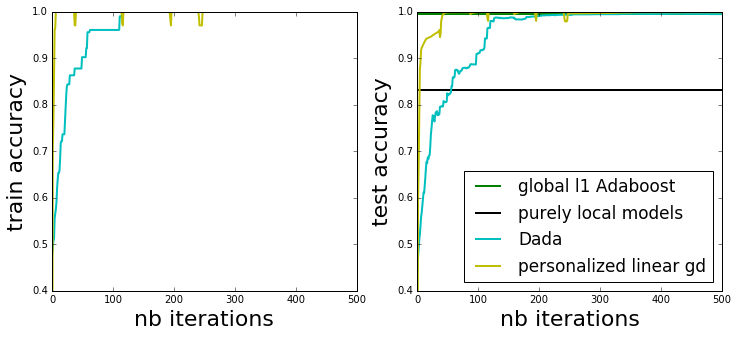

In [62]:
plt.figure(1, figsize=(12, 5))

colors = {
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "personalized linear gd": "y", 
    "Dada": "c",
    "global-local mixture": "y",
}

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='_nolegend_', color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['train-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)
# plt.legend(loc='lower right', fontsize=17)


plt.subplot(122)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=k, color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['test-accuracy']]*(max_iter+1), label=k, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=17)
# plt.legend(bbox_to_anchor=(1.6, 1), fontsize=18)

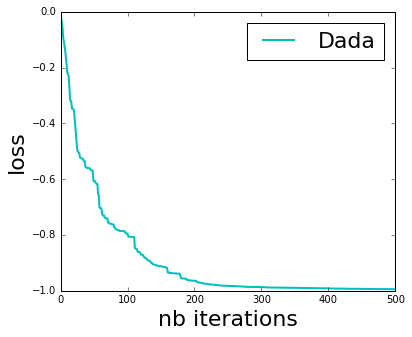

In [63]:
# convergence

max_iter = NB_ITER
plt.figure(1, figsize=(6, 5))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['loss'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        pass

plt.legend(loc='upper right', fontsize=22)

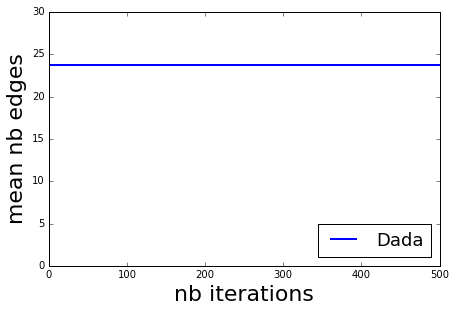

In [64]:
max_iter = NB_ITER

plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0, 30)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)

In [26]:
def get_edges_weights(adj_matrix, similarities):
    edges = []
    weights = []
    for i in range(K):
        for j in range(i, K):
            if adj_matrix[i, j]:
                edges.append((i, j))
                weights.append(similarities[i, j])
    return edges, weights

In [27]:
import networkx as nx

kalo_graph = nx.from_numpy_matrix(results["Dada"][-1]["adj-matrix"])
# uniform_graph = nx.from_numpy_matrix(results["Dada uniform"][-1]["adj-matrix"])

kalo_edges, kalo_weights = get_edges_weights(results["Dada"][-1]["adj-matrix"], results["Dada"][-1]["similarities"])
# uniform_edges, uniform_weights = get_edges_weights(results["Dada uniform"][-1]["adj-matrix"], results["Dada uniform"][-1]["similarities"])

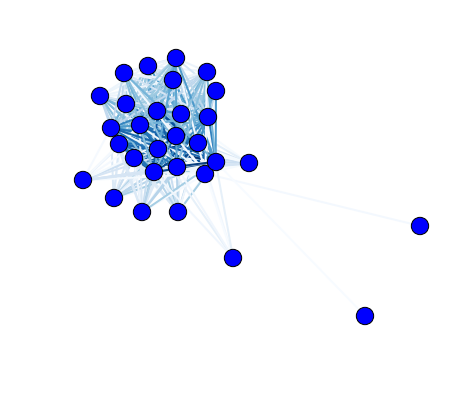

In [67]:
plt.figure(1, figsize=(6, 5))
# plt.suptitle('Learned Graph')
nx.draw(kalo_graph, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

# plt.figure(2, figsize=(10, 5))
# plt.suptitle('Uniform')
# nx.draw(uniform_graph, node_color='b', edgelist=uniform_edges, edge_color=uniform_weights, width=10.0, edge_cmap=plt.cm.Blues)

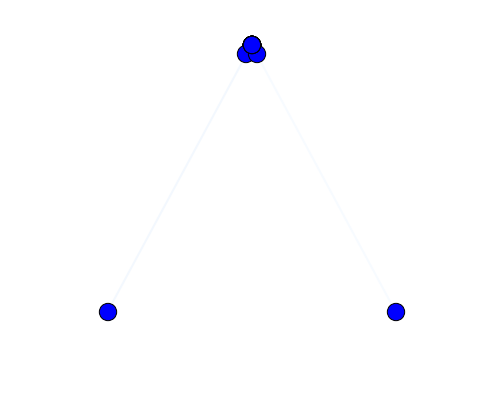

In [68]:
# communities
plt.figure(1, figsize=(6, 5))
# plt.suptitle('Kalofolias')
nx.draw_spectral(kalo_graph, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

# plt.figure(2, figsize=(6, 5))
# plt.suptitle('Uniform')
# nx.draw_spectral(uniform_graph, node_color='b', edgelist=uniform_edges, edge_color=uniform_weights, width=10.0, edge_cmap=plt.cm.Blues)

## Study with communication budget

In [89]:
global_test_accs = []
global_com = []

for k in range(K):
    
    nodes_copy = deepcopy(nodes[:k+1])
    centralized_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
    
    global_com.append(len(nodes[k].sample))
    global_test_accs.append(central_test_accuracy(nodes_copy))

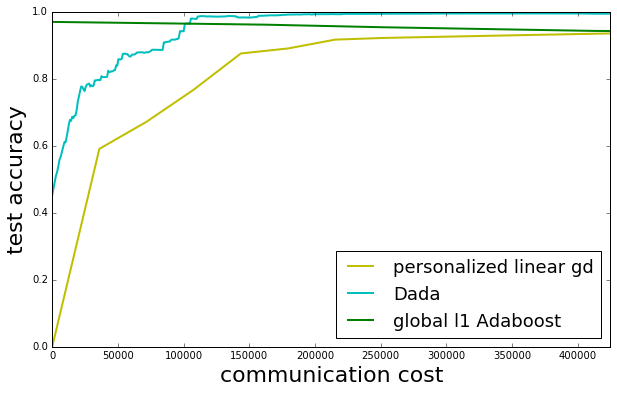

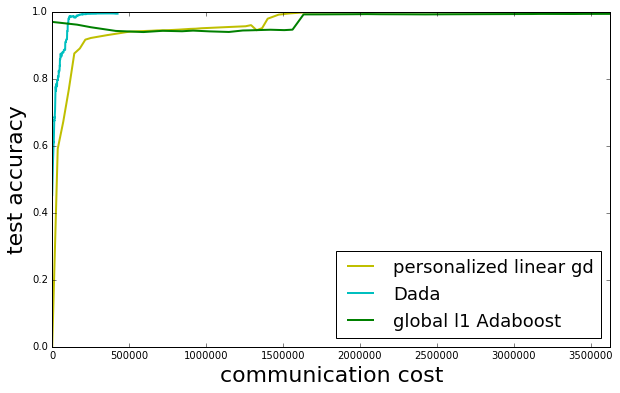

In [96]:
from math import log

Z = 32
# test accuracy vs communication
linear_com = 2*D*Z
regularized_com = [np.sum(r['edges'])/K *(Z + log(n)) for r in results['Dada']]

x_linear = [linear_com*i for i in range(len(results['personalized linear gd']))]
x_dada = [sum(regularized_com[:i]) for i in range(NB_ITER+1)]
x_global = [sum(global_com[:i])*D*Z for i in range(K)]

plt.figure(1, figsize=(10, 6))

plt.xlabel('communication cost', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear gd']], label='personalized linear gd', color=colors['personalized linear gd'], linewidth=2)
plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)
plt.plot(x_global, global_test_accs, label="global l1 Adaboost", color=colors["global l1 Adaboost"], linewidth=2)

plt.xlim(0, min(max(x_dada), max(x_linear), max(x_global)))
plt.ylim(0, 1)
plt.legend(loc="lower right", fontsize=18)

plt.figure(2, figsize=(10, 6))

plt.xlabel('communication cost', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear gd']], label='personalized linear gd', color=colors['personalized linear gd'], linewidth=2)
plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)
plt.plot(x_global, global_test_accs, label="global l1 Adaboost", color=colors["global l1 Adaboost"], linewidth=2)

plt.xlim(0, max(x_global))
plt.ylim(0, 1)
plt.legend(loc="lower right", fontsize=18)

# Walking upstairs vs walking downstairs

In [16]:
# set graph of nodes with local personalized data
NB_ITER = 500
n = 1122

MU = 10
BETA = 1

X, Y, X_test, Y_test, K, max_nb_instances = load_harws(path="../datasets/", walking=True)
D = X[0].shape[1]

# get nodes
nodes = null_graph(X, Y, X_test, Y_test, K, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
#     'edges': [edges, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [17]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [19]:
results["personalized linear gd"], clf_colearning = alternating_colearning(K, X, Y, X_test, Y_test, D, NB_ITER, 
    mu=0.01, la=10, pace_gd=50, max_samples_per_node=max_nb_instances, checkevery=1)

In [20]:
MU, LA = 0.01, 10
STEP = 50

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
    'edges': [edges, []],
    'obj-function': [kalo_objective, [MU, LA]],
}

gd_nodes = deepcopy(nodes)

results["Dada"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": STEP, 
    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=1)

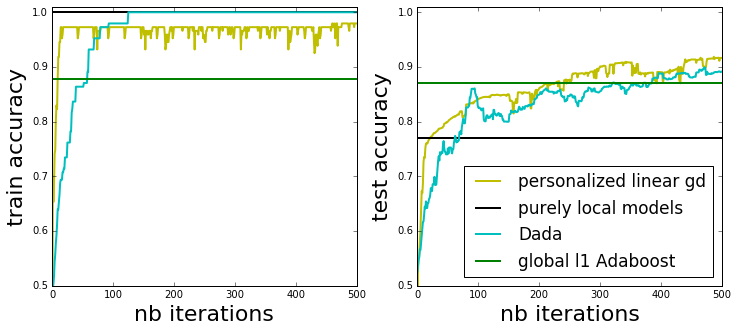

In [21]:
plt.figure(1, figsize=(12, 5))

colors = {
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "personalized linear gd": "y", 
    "Dada": "c",
    "global-local mixture": "y",
}

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.5, 1.01)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='_nolegend_', color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['train-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)
# plt.legend(loc='lower right', fontsize=17)


plt.subplot(122)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.5, 1.01)

for k, r_list in results.items():
    try:
        plt.plot([i for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=k, color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['test-accuracy']]*(max_iter+1), label=k, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=17)
# plt.legend(bbox_to_anchor=(1.6, 1), fontsize=18)

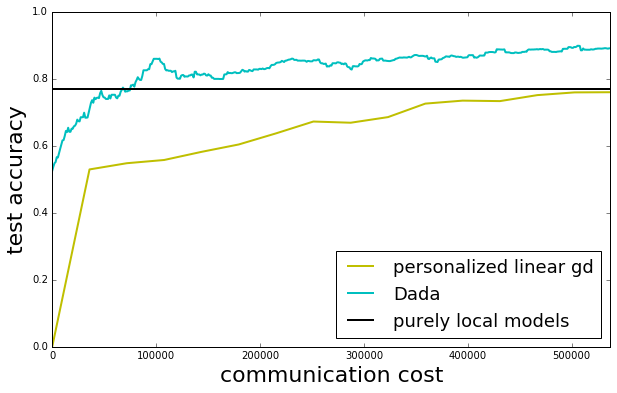

In [22]:
from math import log

Z = 32
# test accuracy vs communication
linear_com = 2*D*Z
regularized_com = [np.sum(r['edges'])/K *(Z + log(n)) for r in results['Dada']]

x_linear = [linear_com*i for i in range(len(results['personalized linear gd']))]
x_dada = [sum(regularized_com[:i]) for i in range(NB_ITER+1)]

plt.figure(1, figsize=(10, 6))

plt.xlabel('communication cost', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear gd']], label='personalized linear gd', color=colors['personalized linear gd'], linewidth=2)
plt.plot(x_dada, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)
plt.plot([0, min(max(x_dada), max(x_linear))], [results["purely local models"]["test-accuracy"]]*2, label='purely local models', color=colors['purely local models'], linewidth=2)

plt.xlim(0, min(max(x_dada), max(x_linear)))
plt.ylim(0, 1)
plt.legend(loc="lower right", fontsize=18)

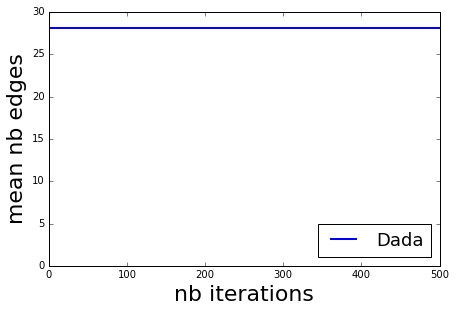

In [23]:
max_iter = NB_ITER

plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0, 30)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)

In [28]:
kalo_graph = nx.from_numpy_matrix(results["Dada"][-1]["adj-matrix"])
# uniform_graph = nx.from_numpy_matrix(results["Dada uniform"][-1]["adj-matrix"])

kalo_edges, kalo_weights = get_edges_weights(results["Dada"][-1]["adj-matrix"], results["Dada"][-1]["similarities"])
# uniform_edges, uniform_weights = get_edges_weights(results["Dada uniform"][-1]["adj-matrix"], results["Dada uniform"][-1]["similarities"])

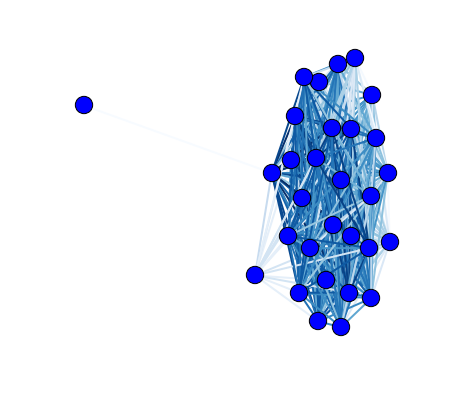

In [29]:
plt.figure(1, figsize=(6, 5))
# plt.suptitle('Learned Graph')
nx.draw(kalo_graph, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

# plt.figure(2, figsize=(10, 5))
# plt.suptitle('Uniform')
# nx.draw(uniform_graph, node_color='b', edgelist=uniform_edges, edge_color=uniform_weights, width=10.0, edge_cmap=plt.cm.Blues)

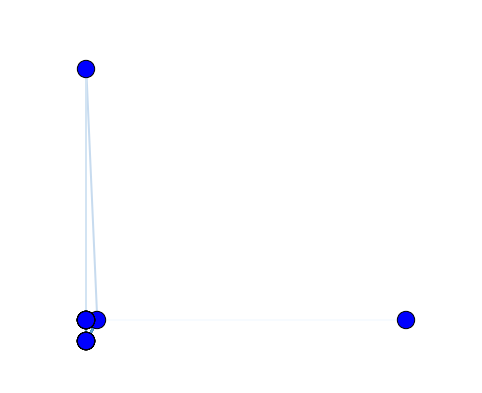

In [30]:
# communities
plt.figure(1, figsize=(6, 5))
# plt.suptitle('Kalofolias')
nx.draw_spectral(kalo_graph, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

# plt.figure(2, figsize=(6, 5))
# plt.suptitle('Uniform')
# nx.draw_spectral(uniform_graph, node_color='b', edgelist=uniform_edges, edge_color=uniform_weights, width=10.0, edge_cmap=plt.cm.Blues)